In [1]:
using Plots

In [2]:
T = 1.0
k_sys = 0.1
t_sh = 0

function eᵥ(t, T_sys0 = 0.58, k_r = 0.83)
    
    T_sys = T_sys0 - (k_sys / T)
    T_r = k_r * T_sys
    
    t %= T
    if ((t_sh + T_sys) <= t < T) || (0.0 <= t < t_sh)    
        return 0.0
    elseif t_sh <= t < (t_sh + T_r)
        num = π * (t - t_sh)
        den = 2T_r
        return sin(num / den)^2
    elseif (t_sh + T_r) <=  t < (t_sh + T_sys)
        num = π * (t - t_sh - T_r)
        den = 2.0 * (T_sys - T_r)
        return cos(num / den)^2
    end
end;

Eₘₐₓ = 2.1
Eₘᵢₙ = 0.06
HR = 75
tc = 60 / HR
Tₘₐₓ = 0.2 + 0.15tc

function Eₙ(tₙ)
    tₙ = (tₙ % T) / Tₘₐₓ
    n₁ = (tₙ / 0.7) ^ 1.9
    n₂ = (tₙ / 1.17) ^ 21.9
    return 1.55 * (n₁ / (1 + n₁)) * (1 / (1 + n₂))
end;

function E(t) 
    return (Eₘₐₓ - Eₘᵢₙ) * Eₙ(t) + Eₘᵢₙ
end;

Definindo o intervalo de tempo:

In [3]:
ϵ = 0.0001
t = 0:ϵ:3T

0.0:0.0001:3.0

In [4]:
lim = map(eᵥ, t)
simaan = map(E, t)

30001-element Vector{Float64}:
 0.06
 0.06000136298301409
 0.060005086826485504
 0.060010990551995
 0.06001898462429003
 0.060029008792710045
 0.060041017800904414
 0.06005497552126654
 0.06007085196094382
 0.06008862152651611
 0.0601082619289763
 0.06012975344902412
 0.06015307842060653
 ⋮
 0.06000000138623445
 0.06000000138321325
 0.06000000138019893
 0.060000001377191484
 0.060000001374190884
 0.06000000137119711
 0.06000000136821017
 0.06000000136523002
 0.06000000136225666
 0.06000000135929007
 0.06000000135633023
 0.06

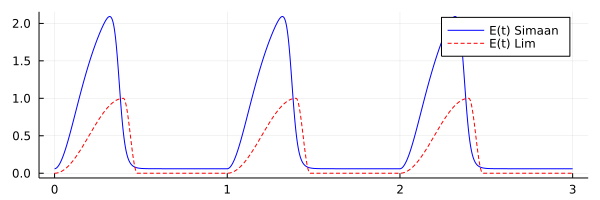

In [5]:
plot(t, simaan, label = "E(t) Simaan", color="blue")
plot!(t, lim, line = :dash, label = "E(t) Lim", size = (600, 200), color="red")

In [10]:
x = fill(0.0, (6, length(t)))
x[:, 1] = [0.0, 10.0, 90.0, 77.0, 0.0, 140.0]
x

6×30001 Matrix{Float64}:
   0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  10.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  90.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  77.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 140.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [11]:
Rₛ = 1.0000
Rₘ = 0.0050
Rₐ = 0.0010
Rc = 0.0398

Cᵣ = 4.4000
Cₛ = 1.3300
Cₐ = 0.0800

Lₛ = 0.0005

V₀ = 10

# mode = "lim"
mode = "simman"

for (i, tᵢ) in enumerate(t)
    if i > 1
        # x1
        
        Dₐ = (x[1, i-1] - x[4, i-1] > ϵ) ? 1. : 0.
        Dₘ = (x[2, i-1] - x[1, i-1] > ϵ) ? 1. : 0.
        
        drma = Dₘ / Rₘ + Dₐ / Rₐ
        
        if mode == "simman"
            x[6, i] = x[6, i-1] + ϵ * (
            ((Dₐ / Rₐ) * x[4, i-1])
            - drma * E(tᵢ) * x[6, i-1]
            + ((Dₘ / Rₘ) * x[2, i-1])
            + drma * E(tᵢ) * V₀
            )
            x[1, i] = E(tᵢ) * (x[6, i] - V₀)
        else
            x[6, i] = x[6, i-1] + ϵ * (
            ((Dₐ / Rₐ) * x[4, i-1])
            - drma * eᵥ(tᵢ)  * x[6, i-1]
            + ((Dₘ / Rₘ) * x[2, i-1])
            + drma * eᵥ(tᵢ)  * V₀
            )
            x[1, i] = eᵥ(tᵢ) * (x[6, i] - V₀)
        end
        
        # x2
        
        RsCr = 1. / (Rₛ * Cᵣ)
        RsCs = 1. / (Rₛ * Cₛ)
        
        CrRm = 1. / (Cᵣ * Rₘ)
        
        x[2, i] = x[2, i-1] + ϵ * (RsCr * (x[3, i-1] - x[2, i-1]) - CrRm * Dₘ * (x[2, i-1] - x[1, i-1]))
        
        # x3
        
        x[3, i] = x[3, i-1] + ϵ * (RsCs * (x[2, i-1] - x[3, i-1]) + (1.0 / Cₛ) * x[5, i-1])
        
        # x4
        
        CaRa = 1. / (Cₐ * Rₐ)
        
        x[4, i] = x[4, i-1] + ϵ * ((-1.0 / Cₐ) * x[5, i-1] + CaRa * Dₐ * (x[1, i-1] - x[4, i-1]))
        
        # x5
        
        x[5, i] = x[5, i-1] + ϵ * ((1. / Lₛ) * (-x[3, i-1] + x[4, i-1] - Rc * x[5, i-1]))
    end
end

In [12]:
x

6×30001 Matrix{Float64}:
   0.0    7.80282    7.80589    7.80922  …    7.70452    7.70481    7.7051
  10.0    9.95636    9.94839    9.94047       7.94478    7.94505    7.94532
  90.0   89.994     89.9878    89.9814       67.8841    67.8799    67.8756
  77.0   77.0       77.0032    77.0097       68.0185    68.0142    68.01
   0.0   -2.6       -5.1781    -7.73379       3.40846    3.4082     3.40795
 140.0  140.044    140.087    140.13     …  138.409    138.413    138.418

In [30]:
plot(plot(t, [x[1,:], x[2,:], x[4,:]], label=["PVE" "PAE" "PAo"]), plot(t, x[5,:], label="Fluxo Aorta", color="purple"), plot(t, x[6,:], label="VVE", color="red"), size=(1600, 400), lw=3)

# Referências

[1] Lim E, Dokos S, Cloherty SL, Salamonsen RF, Mason DG, Reizes JA, Lovell NH.**Parameter-optimized model of cardiovascular–rotary blood pump interactions**. IEEE Transactions on Biomedical Engineering. 2009 Sep 18;57(2):254-66.

[2] Simaan MA, Ferreira A, Chen S, Antaki JF, Galati DG. **A dynamical state space representation and performance analysis of a feedback-controlled rotary left ventricular assist device**. IEEE Transactions on Control Systems Technology. 2008 Dec 22;17(1):15-28.